# Importing Necessary Libraries

In [1]:
# Libraries from PyTorch
import torch
from torch import nn
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader

# Libraries for data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Libraries that makes life easier
from timeit import default_timer as timer
from pathlib import Path
from tqdm.auto import tqdm
import opendatasets as od
import cv2 as cv
from collections import OrderedDict
import os
from torchinfo import summary

# Libraries from Scikit-learn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

###### Execute this next line of code if you are accessing this notebook for the first time

In [2]:
# %run Curating_dataset_from_FER2013

# Loading the curated dataset

In [3]:
# Load and preprocess data
df = pd.read_csv("./FER_curated_dataset.csv")
df

,Unnamed: 0,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,48x40,48x41,48x42,48x43,48x44,48x45,48x46,48x47,48x48,label
0,0,255,255,255,156,213,255,255,128,75,...,255,255,255,255,255,255,124,205,205,0
1,1,177,182,161,183,230,255,252,197,150,...,255,255,217,251,222,83,107,255,248,0
2,2,185,165,164,150,110,120,144,135,118,...,243,240,248,255,255,255,255,255,79,0
3,3,255,255,255,255,255,255,255,255,255,...,111,147,176,203,251,246,234,188,76,0
4,4,15,28,56,89,204,255,255,255,255,...,255,205,128,192,255,255,192,255,171,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4608,4608,255,255,255,255,255,255,255,255,255,...,255,255,255,255,210,157,127,135,155,5
4609,4609,103,160,200,227,243,242,255,255,255,...,255,253,253,251,251,250,250,253,254,5
4610,4610,255,255,255,255,255,244,238,240,252,...,255,255,255,214,255,255,255,255,255,5
4611,4611,209,161,128,119,149,146,176,201,212,...,255,255,255,255,255,255,255,255,255,5


In [4]:
df = df.drop(['Unnamed: 0'], axis=1)
df

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,48x40,48x41,48x42,48x43,48x44,48x45,48x46,48x47,48x48,label
0,255,255,255,156,213,255,255,128,75,167,...,255,255,255,255,255,255,124,205,205,0
1,177,182,161,183,230,255,252,197,150,141,...,255,255,217,251,222,83,107,255,248,0
2,185,165,164,150,110,120,144,135,118,100,...,243,240,248,255,255,255,255,255,79,0
3,255,255,255,255,255,255,255,255,255,255,...,111,147,176,203,251,246,234,188,76,0
4,15,28,56,89,204,255,255,255,255,255,...,255,205,128,192,255,255,192,255,171,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4608,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,210,157,127,135,155,5
4609,103,160,200,227,243,242,255,255,255,255,...,255,253,253,251,251,250,250,253,254,5
4610,255,255,255,255,255,244,238,240,252,255,...,255,255,255,214,255,255,255,255,255,5
4611,209,161,128,119,149,146,176,201,212,229,...,255,255,255,255,255,255,255,255,255,5


In [40]:
class_names = ['angry', 'fear', 'happy', 'neutral', 'sad', 'shock']

Text(0.5, 1.0, 'angry')

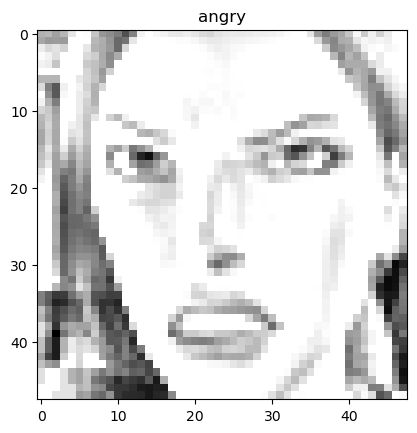

In [41]:
plt.imshow(df.iloc[1,:-1].values.reshape(48,48),cmap='gray')
class_ = df.iloc[1,-1]
plt.title(class_names[class_])

# Accessing the images and the labels

In [5]:
# From train.csv
x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [6]:
x,y

(array([[255, 255, 255, ..., 124, 205, 205],
        [177, 182, 161, ..., 107, 255, 248],
        [185, 165, 164, ..., 255, 255,  79],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [209, 161, 128, ..., 255, 255, 255],
        [212, 213, 215, ..., 244, 255, 254]], dtype=int64),
 array([0, 0, 0, ..., 5, 5, 5], dtype=int64))

In [7]:
# Verify feature sizes
print("Feature shape before reshaping:", x.shape)

# Ensure the correct feature size
if x.shape[1] != 48 * 48:
    raise ValueError(f"Each feature should have 2304 elements, but got {x.shape[1]}")

Feature shape before reshaping: (4613, 2304)


# Defining a Custom Dataset

In [8]:
class class_Dataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features.astype(np.float32)  # Ensure features are float32
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        
        # Reshape the feature into the original image shape (48, 48)
        feature = feature.reshape(48, 48)
        
        if self.transform:
            feature = self.transform(feature)
        
        return feature, label

# Applying transformations to the dataset

In [9]:
# Define transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors and scale to [0, 1]
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize images
])

# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42) 

# Create instances of the custom dataset
train_dataset = class_Dataset(X_train, y_train, transform=transform)
test_dataset = class_Dataset(X_test, y_test, transform=transform)
len(train_dataset),len(train_dataset)

(3690, 3690)

# Creating DataLoaders

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x24da68ae250>,
 <torch.utils.data.dataloader.DataLoader at 0x24db94c7690>)

# Setting-up device agnostic code

In [11]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
# device = torch.device('cpu')
device

device(type='cuda')

# Building the Model

In [12]:
class DetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,padding=1)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,padding=1)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216,1024),
            nn.ReLU(),
            nn.Linear(1024,1024),
            nn.ReLU(),
            nn.Linear(1024,6)
        )
    
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        
        return x
    
model = DetectionModel().to(device)
model

DetectionModel(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10

In [13]:
summary(model,input_shape=(1,1,48,48))

Layer (type:depth-idx)                   Param #
DetectionModel                           --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       18,496
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
├─Sequential: 1-4                        --
│    └─Flatten: 2-15                     --
│    └─Linear: 2-16                      9,438,

# Setting-up Loss Function and optimizer

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.00001)

# Code for stopping the training loop early

In [19]:
# Early stopping class definition (if not already defined)
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pth')
        if self.verbose:
            print(f'Validation loss decreased. Saving model ...')

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, verbose=True)

In [20]:
train_images,train_labels = next(iter(train_dataloader))
print(f"Shape of image: {train_images.shape} | Shape of label: {train_labels.shape}")

Shape of image: torch.Size([64, 1, 48, 48]) | Shape of label: torch.Size([64])


# Making the Training Loop

In [21]:
# Training loop
num_epochs = 60
trainloss, testloss = [], []
trainaccuracy, testaccuracy = [], []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    
    for train_images, train_labels in train_dataloader:
        train_images, train_labels = train_images.to(device), train_labels.to(device)
        optimizer.zero_grad()
        outputs = model(train_images)
        train_loss = loss_fn(outputs, train_labels)
        train_loss.backward()
        optimizer.step()
        
        _, train_pred = torch.max(outputs.data, dim=1)
        correct_train += (train_pred == train_labels).sum().item()
        running_train_loss += train_loss.item()
    
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_accuracy = 100 * correct_train / len(train_dataloader.dataset)
    
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    
    with torch.no_grad():
        for test_images, test_labels in test_dataloader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)
#             train_labels = train_labels.view(train_images.size(0), train_images.size(2), train_images.size(3))
#             print(train_images.shape)
#             print(train_labels.shape)
            test_outputs = model(test_images)
            test_loss = loss_fn(test_outputs, test_labels)
            _, test_pred = torch.max(test_outputs.data, 1)
            correct_test += (test_pred == test_labels).sum().item()
            running_test_loss += test_loss.item()
    
    avg_test_loss = running_test_loss / len(test_dataloader)
    test_accuracy = 100 * correct_test / len(test_dataloader.dataset)
    
    trainloss.append(avg_train_loss)
    testloss.append(avg_test_loss)
    trainaccuracy.append(train_accuracy)
    testaccuracy.append(test_accuracy)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%')
    
#     early_stopping(avg_test_loss, model)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

# Load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pth'))


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/60] | Train Loss: 1.5535 | Train Accuracy: 42.60% | Test Loss: 1.4482 | Test Accuracy: 41.17%
Epoch [2/60] | Train Loss: 1.2267 | Train Accuracy: 55.47% | Test Loss: 1.1458 | Test Accuracy: 54.60%
Epoch [3/60] | Train Loss: 1.0110 | Train Accuracy: 62.09% | Test Loss: 1.0375 | Test Accuracy: 57.96%
Epoch [4/60] | Train Loss: 0.8773 | Train Accuracy: 67.43% | Test Loss: 0.9593 | Test Accuracy: 60.89%
Epoch [5/60] | Train Loss: 0.7861 | Train Accuracy: 70.35% | Test Loss: 0.8843 | Test Accuracy: 65.11%
Epoch [6/60] | Train Loss: 0.7631 | Train Accuracy: 70.70% | Test Loss: 0.8852 | Test Accuracy: 65.66%
Epoch [7/60] | Train Loss: 0.7151 | Train Accuracy: 73.31% | Test Loss: 0.8738 | Test Accuracy: 66.09%
Epoch [8/60] | Train Loss: 0.6842 | Train Accuracy: 74.28% | Test Loss: 0.8279 | Test Accuracy: 66.52%
Epoch [9/60] | Train Loss: 0.6499 | Train Accuracy: 75.69% | Test Loss: 0.8035 | Test Accuracy: 68.91%
Epoch [10/60] | Train Loss: 0.6284 | Train Accuracy: 75.85% | Test Loss: 

<All keys matched successfully>

In [22]:
torch.save(model,'./mood-detector.pth')

In [26]:
epochs = np.arange(0,60,1)
epochs

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

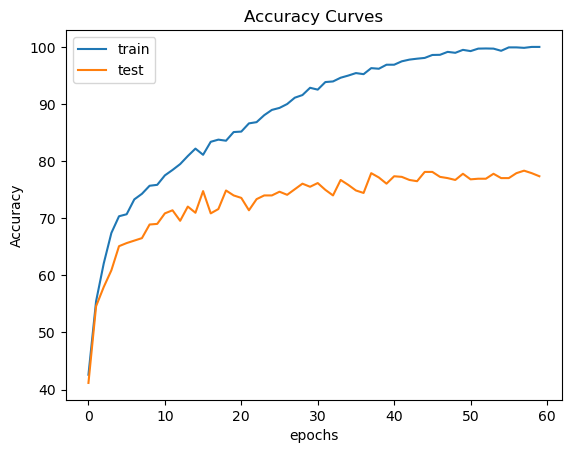

In [27]:
plt.plot(epochs,trainaccuracy,label='train')
plt.plot(epochs,testaccuracy,label='test')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.show()

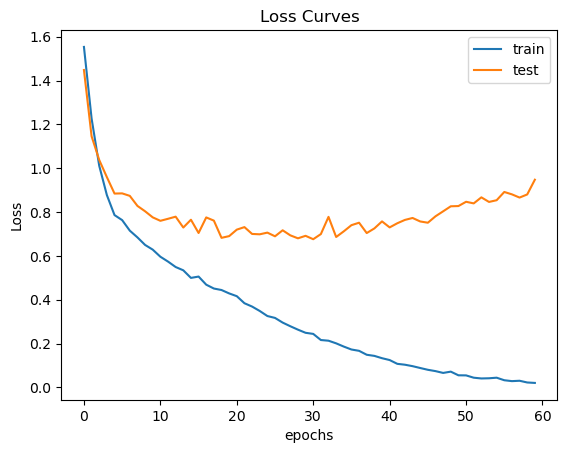

In [28]:
plt.plot(epochs,trainloss,label='train')
plt.plot(epochs,testloss,label='test')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

In [4]:
model = torch.load("./mood-detector.pth",map_location=torch.device('cpu'))

AttributeError: Can't get attribute 'DetectionModel' on <module '__main__'>

In [68]:
img_arr = df.iloc[4500,:-1].values
img_arr = img_arr.astype('float32')
img_tensor = torch.tensor(img_arr)
class_original = df.iloc[4500,-1]
class_name = class_names[class_original]
img_arr , img_tensor , class_name

(array([255., 255., 228., ..., 255., 255., 255.], dtype=float32),
 tensor([255., 255., 228.,  ..., 255., 255., 255.]),
 'shock')

In [69]:
# img_tensor = img_tensor.type('float32')
img_tensor = img_tensor.reshape(1,1,48,48)
logit = model(img_tensor)
pred = torch.softmax(logit.squeeze(),dim=0)
class_ = torch.argmax(pred).item()
class_name = class_names[class_]
class_name

'shock'

[]

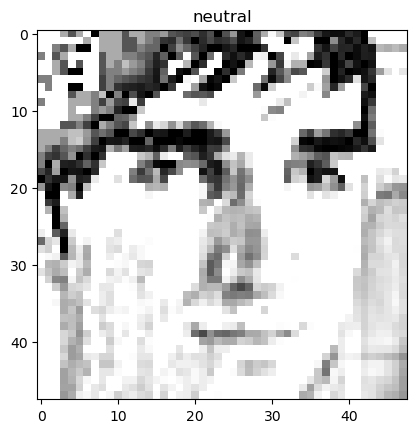

In [67]:
plt.imshow(img_arr.reshape(48,48),cmap='gray')
plt.title(class_name)
plt.plot()

In [114]:
img_path = "./arnav.jpg"

In [115]:
img = cv.imread(img_path)
img = cv.resize(img,(48,48))
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
inverted = 255 - gray
blurred = cv.GaussianBlur(inverted,(21,21),0)
drawing = cv.divide(gray,255 - blurred, scale=256)
flat = drawing.flatten()

In [116]:
img_arr = flat.astype('float32')
img_arr

array([255., 255., 255., ..., 255., 255., 255.], dtype=float32)

In [119]:
img_tensor = torch.tensor(img_arr)
img_tensor = img_tensor.reshape(1,1,48,48)
logit = model(img_tensor)
pred = torch.softmax(logit.squeeze(),dim=0)
print(pred)
class_ = torch.argmax(pred).item()
print(class_)
class_name = class_names[class_]
class_name

tensor([1.0900e-02, 3.8143e-02, 1.6976e-01, 7.7991e-01, 1.1173e-03, 1.6647e-04],
       grad_fn=<SoftmaxBackward0>)
3


'neutral'

Text(0.5, 1.0, 'neutral')

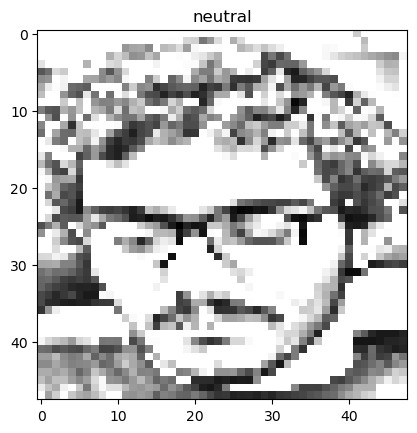

In [118]:
plt.imshow(drawing,cmap='gray')
plt.title(class_name)